# Salary Prediction from Job Description

In [1]:
import os
%pylab inline
import re
import pandas as pd
from pandas import Series, DataFrame
import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import statsmodels.api as sm
from patsy import dmatrices
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('english'))

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Read files
os.chdir('D:\UT Austin\Fall\MIS-284N-Text-Analytics-master')
df_raw = pd.read_csv(r'Train_rev1.csv')
df_train = df_raw.sample(2500)
df_train.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
154523,71014022,"Regulatory Policy, Energy Markets",US company launching in London for the first t...,London,London,full_time,permanent,G2 Legal LTD,Legal Jobs,"From 75,000 to 100,000 per year",87500,TotallyLegal
148095,70759614,Retail Marketing Manager,"Our client, one the most innovative taking the...",North West,North West London,NaN,permanent,NaN,"PR, Advertising & Marketing Jobs",30k - 40k,35000,simplymarketingjobs.co.uk
30969,68068843,Dialler Analyst,PACT are pleased to be supporting a well estab...,South Yorkshire Yorkshire,South Yorkshire,NaN,permanent,Pact,Other/General Jobs,20000 - 25000 per annum + Benefits,22500,totaljobs.com
163848,71227379,Client Development Manager,Affinion International Client Development Mana...,"Slough, Berkshire",Slough,full_time,permanent,Affinion International Limited,Accounting & Finance Jobs,"40,000 to 45,000 per anuum",42500,fish4.co.uk
85967,69084010,Shift Leader,My clients who are a medium sized maintenance ...,"Reading, Berkshire",Reading,NaN,permanent,Invictus Group,Engineering Jobs,"32000 - 35000/annum OT , Training",33500,cv-library.co.uk


Parts of speech distribution with and without removal of stopwords

In [3]:
df_train = df_train[['Id','FullDescription','SalaryNormalized']]
df_train['FullDescription'] = df_train['FullDescription'].map(str.lower)

In [4]:
#Tag all parts of speech
pos_dt = {}

#Function to split a job description into words and tag POS
def pos_count(desc):
    tokens = re.findall('\w+', desc)
    tokenlist = nltk.pos_tag(tokens, tagset='universal')
    
    for t in tokenlist:
        pos = t[1]
        if pos in pos_dt:
            pos_dt[pos] += 1
        else:
            pos_dt[pos] = 1
    
    return desc

#Map function
df_train['FullDescription'].map(pos_count)

pos_dt

{u'.': 27,
 u'ADJ': 73861,
 u'ADP': 66773,
 u'ADV': 16725,
 u'CONJ': 31811,
 u'DET': 53638,
 u'NOUN': 218478,
 u'NUM': 4877,
 u'PRON': 22515,
 u'PRT': 21509,
 u'VERB': 111067,
 u'X': 353}

In [5]:
#Same as above, but stop words were removed
pos_nostop_dt = {}

def pos_nostop_count(desc):
    tokens = re.findall('\w+', desc)
    filtered_tokens = [w for w in tokens if not w in stop_words]
    
    tokenlist = nltk.pos_tag(filtered_tokens, tagset='universal')
    
    for t in tokenlist:
        pos = t[1]
        if pos in pos_nostop_dt:
            pos_nostop_dt[pos] += 1
        else:
            pos_nostop_dt[pos] = 1
    
    return desc

df_train['FullDescription'].map(pos_nostop_count)

pos_nostop_dt

{u'.': 23,
 u'ADJ': 76142,
 u'ADP': 6178,
 u'ADV': 13822,
 u'CONJ': 516,
 u'DET': 285,
 u'NOUN': 211942,
 u'NUM': 4904,
 u'PRON': 600,
 u'PRT': 82,
 u'VERB': 74508,
 u'X': 463}

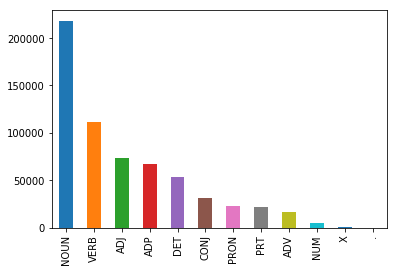

In [6]:
#Top 5 POS still including stop words
Series(pos_dt).sort_values(ascending=False).plot(kind='bar')

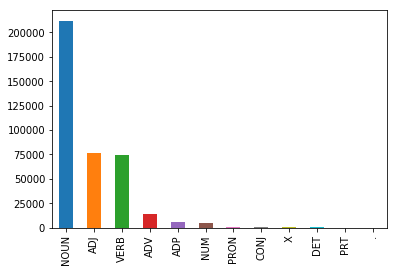

In [7]:
#Top 5 POS after removing stop words
Series(pos_nostop_dt).sort_values(ascending=False).plot(kind='bar')

Nouns make up over 200k words of the roughly 400k in the 2500 job descriptions. 

The number of verbs decreased by about 40k after removing stop words. Adposition words (ADP) decreased by over 60k when removing stop words because this category contains words such as "with" and "to". Determiners (DET) decreased from around 60k to barely 200 words because this category contains words such as "a" and "the".

In [8]:
#Concatenate all descriptions into one string and split into words
a = df_train['FullDescription'].str.cat(sep = ' ')
s = re.findall('\w+', a)
s = Series(s)

#Get word counts
df_words = DataFrame(s.value_counts())
df_words = df_words.reset_index()
df_words.columns = ['Word','Counts']

## Validating Zipf's Law 

In [9]:
#Rank words by count, take log of rank and log of count
df_words['Rank'] = df_words['Counts'].rank(ascending=False)
constant = df_words.iloc[-1]['Counts']*df_words.iloc[-1]['Rank']
df_words['LogCount'] = log(df_words['Counts']/constant)
df_words['LogRank'] = log(df_words['Rank'])

#Run and plot linear regression on the log-log relationship
Y, X = dmatrices('LogRank~LogCount', data=df_words, return_type='dataframe')
model = sm.OLS(Y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                LogRank   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 9.857e+05
Date:                Wed, 19 Sep 2018   Prob (F-statistic):               0.00
Time:                        01:39:11   Log-Likelihood:                 10729.
No. Observations:               18167   AIC:                        -2.145e+04
Df Residuals:                   18165   BIC:                        -2.144e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5702      0.005    664.302      0.0

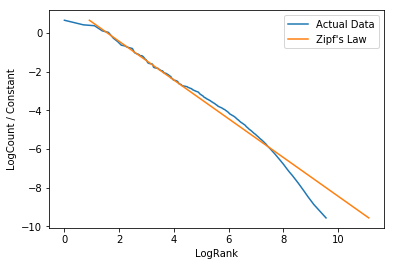

In [10]:
plot(df_words['LogRank'],df_words['LogCount'], linestyle='-', label='Actual Data')
xlabel('LogRank')
ylabel('LogCount / Constant')
plot(log(constant)-df_words['LogCount']-8,df_words['LogCount'], linestyle='-', label="Zipf's Law")
legend(loc='best')

After linear regression, the log(count/min count) has a coefficient of -0.6 with respect to log(rank) so our dataset only loosely follows Zipf's law. 

A large number of words with low frequencies "flatten" the curve because the change from word to the next does not exactly follow the inverse-rank stated by Zipf's law.

## Validating Zipf's law for only top 100 words 

In [11]:
#Same regression but using only the top 100 words
Y, X = dmatrices('LogRank~LogCount', data=df_words[0:100], return_type='dataframe')
model = sm.OLS(Y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                LogRank   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     8937.
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           4.34e-98
Time:                        01:39:11   Log-Likelihood:                 92.270
No. Observations:                 100   AIC:                            -180.5
Df Residuals:                      98   BIC:                            -175.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4029      0.026     54.894      0.0

Looking at only the 100 most frequent words results in a rank-count relationship that follows Zipf's law much closer with a coefficient of almost exactly -1

In [12]:
df_words.set_index('Word',inplace=True)

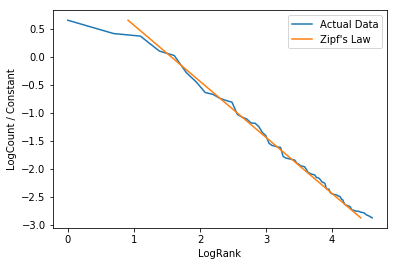

In [13]:
plot(df_words.iloc[0:100]['LogRank'],df_words.iloc[0:100]['LogCount'], linestyle='-', label='Actual Data')
xlabel('LogRank')
ylabel('LogCount / Constant')
plot(log(constant)-df_words.iloc[0:100]['LogCount']-8,df_words.iloc[0:100]['LogCount'], linestyle='-', label="Zipf's Law")
legend(loc='best')

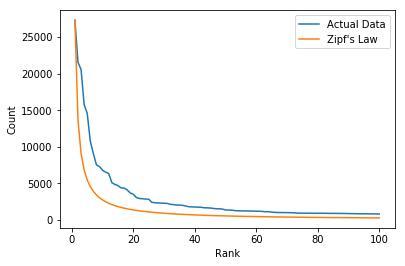

In [14]:
plot(df_words.iloc[0:100]['Rank'],df_words.iloc[0:100]['Counts'], linestyle='-', label='Actual Data')
xlabel('Rank')
ylabel('Count')

df_words['Zipf'] = df_words.iloc[0]['Counts']/df_words['Rank']

plot(df_words.iloc[0:100]['Rank'],df_words.iloc[0:100]['Zipf'], linestyle='-', label="Zipf's Law")
legend(loc='best')

The graph above plots the rank and frequency of the top 100 words in our job descriptions in comparison. The actual word frequencies are higher in the top 100 than Zipf's law would predict, but it follows the general rule that a few words (top 10) have very high frequencies and the counts drop dramatically after the top 20. In the log-log graph, the line for Zipf's law was shifted because of the high intercept value attained from the regression of all 100k+ words.

After Lemmatization

In [15]:
s = re.findall('\w+', a)
s = [w for w in s if not w in stop_words]

lemmatizer = WordNetLemmatizer()
s = Series(s).map(lemmatizer.lemmatize)

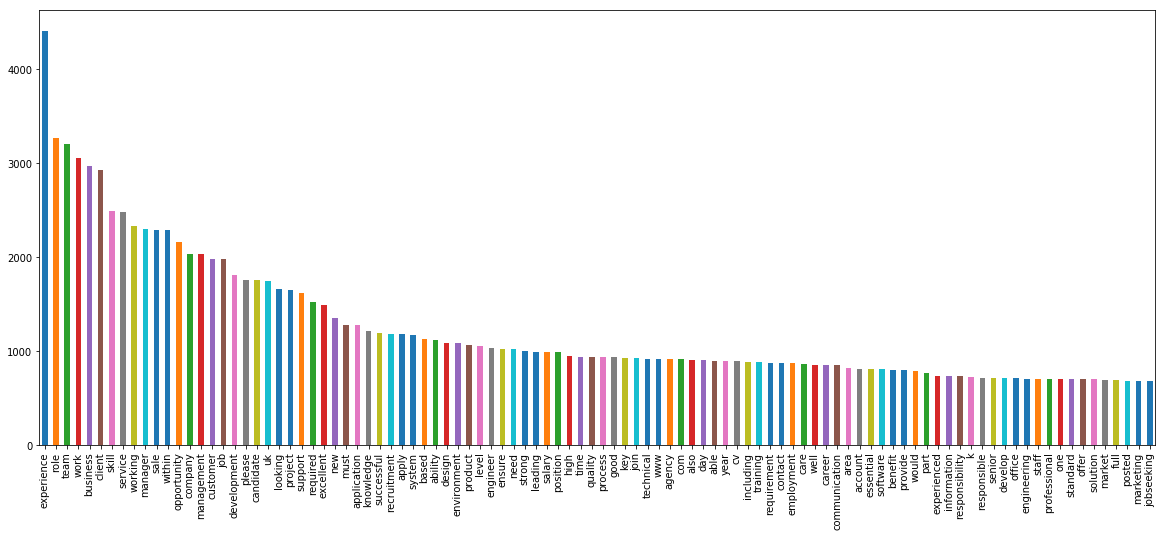

In [16]:
pylab.rcParams['figure.figsize'] = (20, 8)
s.value_counts()[:100].plot(kind='bar')


Experience is the most common word by far, showing up more than 4,000 times in 2,500 job descriptions

# Naive Bayes Classifier on catergorical columns 

In [17]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

In [18]:
df_train = df_raw.dropna().sample(2500)
cutoff = df_train['SalaryNormalized'].quantile(0.75)

df_train['HighSalary'] = 0
df_train['HighSalary'][df_train['SalaryNormalized']>cutoff] = 1

df_train.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,HighSalary
5816,62044740,Technical Consultant,"Our client, a global consulting firm, is curre...",Belfast,Belfast,full_time,permanent,Abacus Professional Recruitment,Consultancy Jobs,"50,000 - 60,000",55000,nijobfinder.co.uk,1
7189,64585451,Technical Services Engineer,&nbspJob Title: Installation Engineer/Technica...,Cheshire,Cheshire,full_time,permanent,OCC Computer Personnel/RI,Engineering Jobs,34500,34500,strike-jobs.co.uk,0
218619,72331033,JAVA/RESTFUL DEVELOPER ASYNCHRONOUS PROGRAMMING,Java/ Restful developer Asynchronous Programm...,Kent,Kent,full_time,permanent,Hatstand Ltd,Teaching Jobs,30000.00 - 40000.00 GBP Annual,35000,jobs.newstatesman.com,0
37854,68294381,Band 6 Occupational Therapist Paediatrics,MedicsPro are acting on behalf of our client b...,Isle Of Man,Isle Of Man,full_time,permanent,UKStaffsearch,Admin Jobs,42240 - 84480,63360,ukstaffsearch.com,1
218605,72330182,Online Marketing Executive trendy website,"Expanding globally, my awarding winning client...",Central London,Central London,full_time,permanent,SPOTLIGHT RECRUITMENT,Travel Jobs,"25000 - 28000 per annum + Bonus, holiday + more!",26500,jobs.guardian.co.uk,0


In [19]:
df_nbtrain = pd.get_dummies(df_train[['ContractType','ContractTime','Category']])

#Cities where avg rent is >= 20% of avg income
high_cities = ['London', 'Central London','The City','Brighton','Edinburgh','Bristol','Southampton','Portsmouth','Exeter'\
                 ,'Cardiff', 'Manchester', 'Birmingham', 'Leeds', 'Aberdeen', 'Glasgow', 'Newcastle', 'Sheffield', 'Liverpool', 'Hull']

a = df_train['LocationNormalized']
b = []

#Create dummy variable for expensive cities
for i in range(len(a)):
    if a.iloc[i] in high_cities: 
        b.append(1)
    else: b.append(0)


df_nbtrain['ExpensiveCity'] = b
df_nbtrain['HighSalary'] = df_train['HighSalary']

#Drop extra dummies
df_nbtrain = df_nbtrain.drop(['ContractType_part_time','ContractTime_contract','Category_Travel Jobs'], axis=1)
df_nbtrain.head()


,ContractType_full_time,ContractTime_permanent,Category_Accounting & Finance Jobs,Category_Admin Jobs,Category_Charity & Voluntary Jobs,Category_Consultancy Jobs,Category_Creative & Design Jobs,Category_Customer Services Jobs,Category_Domestic help & Cleaning Jobs,"Category_Energy, Oil & Gas Jobs",...,"Category_PR, Advertising & Marketing Jobs",Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,ExpensiveCity,HighSalary
5816,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7189,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218619,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
37854,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
218605,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
from sklearn import naive_bayes
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn import metrics

In [21]:
dummy_column_names = list(df_nbtrain.columns.values)[:-1]

formula = 'HighSalary ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))

nbtrain, nbtest = train_test_split(df_nbtrain, test_size=0.3)
    
#Training Sets
Ytrain, xtrain = dmatrices(formula, nbtrain, return_type='dataframe')
ytrain = Ytrain['HighSalary'].values

#Testing Set
Ytest, xtest = dmatrices(formula, nbtest, return_type='dataframe')
ytest = Ytest['HighSalary'].values

model = naive_bayes.MultinomialNB()
model.fit(xtrain, ytrain)

prediction_train = model.predict(xtrain)
print ("Training Accuracy")
print (metrics.accuracy_score(ytrain, prediction_train))

print (" ")
print ("Test Accuracy")
prediction_test = model.predict(xtest)
print (metrics.accuracy_score(ytest, prediction_test))

#Baseline accuracy = if we guessed 'No' for all of them
print (" ")
print ("Baseline Accuracy")
print (1-ytest.mean())

#Row 1 is all the ones low salary
#Column 1 is all the ones predicted low salary
print(' ')
print (metrics.confusion_matrix(ytest, prediction_test))

Training Accuracy
0.768
 
Test Accuracy
0.7493333333333333
 
Baseline Accuracy
0.7493333333333334
 
[[562   0]
 [188   0]]


A Binomial Naive Bayes model using every variable except the job description essentially predicts a "Low Salary" for every job and underperforms even the baseline accuracy.

# Naive Bayes on 'Job Description'

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from operator import itemgetter
from sklearn.metrics import classification_report
import csv
import os

In [23]:
df_text = df_train[['FullDescription','HighSalary']]
df_text['FullDescription'] = df_text['FullDescription'].dropna().str.lower().str.replace('\d+', '')\
.map(lambda x:re.findall('\w+',x)).map(lambda x:' '.join([i for i in x if i not in stop_words \
                                                          and i not in string.punctuation]))

In [24]:
#Split Train and Test sets
#Split descriptions from salary range
X_train, X_test, y_train, y_test = train_test_split(df_text['FullDescription'],
                                                    df_text['HighSalary'],
                                                    test_size=0.3, random_state=1)

In [25]:
#Like the document term matrix, but filled with 1's and 0's instead of TFIDF scores
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

#Fit model on train data
clf = BernoulliNB().fit(X_train_counts, y_train)

#Predict using X_test data
prediction = clf.predict(X_test_counts)

In [26]:
#Percent correct overall
print ('Prediction Accuracy')
print (metrics.accuracy_score(y_test, prediction))
print('  ')
#Baseline accuracy = if we guessed 'No' for all of them
print ('Baseline Accuracy')
print (1-y_test.mean())

Prediction Accuracy
0.7973333333333333
  
Baseline Accuracy
0.76


In [27]:
#Row 1 is all the ones low salary
#Column 1 is all the ones predicted low salary
metrics.confusion_matrix(y_test, prediction)

array([[529,  41],
       [111,  69]], dtype=int64)

Accuracy is high on the Low salary jobs, but below 50% on the high salary jobs.

# Most Indicative Features

In [28]:
commonimp = abs(clf.feature_log_prob_[1]-clf.feature_log_prob_[0])

topcommon = Series(commonimp,index=count_vect.get_feature_names()).sort_values(ascending=False)
topcommon[0:10]

teachers    3.388780
cycles      3.111008
ca          2.956857
ofsted      2.912440
teach       2.877954
cfo         2.774535
underpin    2.774535
cognos      2.774535
ccg         2.774535
ssrs        2.774535
dtype: float64

The words above are the most indicative in our model for predicting salary, either high or low.

In [29]:
highimp = clf.feature_log_prob_[1]-clf.feature_log_prob_[0]

tophigh = Series(highimp,index=count_vect.get_feature_names()).sort_values(ascending=False)
tophigh[0:10]

cycles       3.111008
ca           2.956857
underpin     2.774535
mrics        2.774535
footprint    2.774535
ccg          2.774535
cognos       2.774535
ssrs         2.774535
fmea         2.774535
rics         2.774535
dtype: float64

The words above are the top 10 most indicative of high salary jobs in this model. They seem to describe specific high-level positions that involve things such as negotiations and strategic decisions.

In [30]:
lowimp = clf.feature_log_prob_[1]-clf.feature_log_prob_[0]

toplow = Series(highimp,index=count_vect.get_feature_names()).sort_values(ascending=False)
toplow[-10:]

maths        -2.472489
nvq          -2.548475
qts          -2.548475
curriculum   -2.619092
ks           -2.641565
teacher      -2.692117
classroom    -2.746926
teach        -2.877954
ofsted       -2.912440
teachers     -3.388780
dtype: float64

The words above are the top 10 most indicative of low salary jobs in this model. They seem to center around school and teaching positions, with the exception of technicians which are commonly also low-level jobs.

# Naive Bayes on Hybrid model

Train a “hybrid” model to predict high/low salary using both numeric and text data. Show the accuracy of the model. 

In [31]:
df_hybrid = df_text.join(df_nbtrain.drop('HighSalary',axis=1))

X_htrain, X_htest, y_htrain, y_htest = train_test_split(df_hybrid.drop('HighSalary',axis=1),
                                                    df_hybrid['HighSalary'],
                                                    test_size=0.3, random_state=1)

In [32]:
X_htrain_words = count_vect.fit_transform(X_htrain['FullDescription'])
X_htrain_counts = DataFrame(X_htrain_words.todense()).join(X_htrain.drop('FullDescription',axis=1).reset_index())

In [33]:
X_htest_words = count_vect.transform(X_htest['FullDescription'])
X_htest_counts = DataFrame(X_htest_words.todense()).join(X_htest.drop('FullDescription',axis=1).reset_index())

In [34]:
#Fit model on train data
hybrid_model = BernoulliNB().fit(X_htrain_counts, y_htrain)

#Predict using X_test data
hybrid_prediction = hybrid_model.predict(X_htest_counts)

#Percent correct overall
print ('Prediction Accuracy')
print (metrics.accuracy_score(y_htest, hybrid_prediction))
print('  ')
#Baseline accuracy = if we guessed 'No' for all of them
print ('Baseline Accuracy')
print (1-y_htest.mean())

Prediction Accuracy
0.7933333333333333
  
Baseline Accuracy
0.76


In [35]:
#Row 1 is all the ones low salary
#Column 1 is all the ones predicted low salary
metrics.confusion_matrix(y_htest, hybrid_prediction)

array([[526,  44],
       [111,  69]], dtype=int64)

Even though accuracy increased for "High Salary" jobs, it decreased when predicting the "Low Salary" jobs, which make up 75% of the data. This is not surprising because we saw earlier that the dummy variables such as job category have little to no predictive power.